# Improecd RAG with Query Augmentation and Cross Encoding

this notebook is modified from [Advanced Retrieval for AI with Chroma](https://learn.deeplearning.ai/courses/advanced-retrieval-for-ai)

The project is partially funded by the [OpenAI Research Assistant Grant](https://medium.com/@Stan_DS/what-i-learned-to-successfully-apply-for-openai-research-program-78edd2f93655).

In [106]:
from helper_utils import word_wrap

from pypdf import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv

import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

from sentence_transformers import CrossEncoder

_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [ ]:
# load tesla 2023 10K report

reader = PdfReader("../data/tesla10K.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]

# split text by sentences
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print(word_wrap(character_split_texts[10]))
print(f"\nTotal chunks: {len(character_split_texts)}")

# tokenize the sentence chunks
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(word_wrap(token_split_texts[10]))
print(f"\nTotal chunks: {len(token_split_texts)}")

### create sentence embedding 

In [5]:
# create embeddings

embedding_function = SentenceTransformerEmbeddingFunction()

[[-0.02610541507601738, 0.03637726604938507, 0.016850141808390617, 0.013502818532288074, 0.03193788602948189, 0.01282839197665453, -0.06844824552536011, -0.018723037093877792, -0.004075437318533659, 0.03759795427322388, 0.0805976539850235, 0.03495503216981888, -0.0011632046662271023, -0.09199048578739166, -0.02890200912952423, 0.01442332100123167, -0.010951112024486065, 0.004289309494197369, -0.021638033911585808, 0.13033165037631989, -0.0065737441182136536, 0.0645902156829834, -0.012173376977443695, 0.09703105688095093, 0.04759971424937248, -0.00017682572070043534, 0.011732799932360649, 0.013724432326853275, -0.008537139743566513, 0.00817929394543171, -0.054263681173324585, 0.028767231851816177, -0.005877642892301083, -0.00530084315687418, 0.08447010070085526, 0.03450290486216545, -0.03226642310619354, 0.01503743976354599, 0.006114393472671509, -0.022774161770939827, 0.0320158377289772, -0.05341488867998123, -0.025782618671655655, 0.03530915454030037, -0.04098166897892952, -0.02924984

In [ ]:
#### create vector data base using chromaDB collection

In [10]:
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("tesla202310k", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

556

In [45]:

query = "What was the total revenue?"

### retrieve top n similar embeddings from chroma collection
results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(word_wrap(document))
    print('\n')

million and $ 106 million, respectively, in cost of revenues in the
consolidated statements of operations. 72


participation activities. such guarantees and variable customer
payments represent a form of variable consideration and are estimated
at contract inception at their most likely amount and updated at the
end of each reporting period as additional performance data becomes
available. such estimates are included in the transaction price only to
the extent that it is probable a significant reversal of revenue will
not occur. we record as deferred revenue any non - refundable amounts
that are collected from customers related to fees charged for
prepayments, which is recognized as revenue ratably over the respective
customer contract term. as of december 31, 2023 and 2022, deferred
revenue related to such customer payments amounted to $ 1. 60 billion
and $ 863 million, respectively, mainly due to contractual payment
terms. revenue recognized from the deferred revenue balance as of
d


#### use LLM (Openai API) to answer human query

In [46]:
def rag(query, retrieved_documents, model="gpt-3.5-turbo"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about information contained in an annual 10K report."
            "You will be shown the user's question, and the relevant information from the annual report. Answer the user's question using only this information."
        },
        {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
    ]
    
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [47]:
query = "What was the total revenue?"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

output = rag(query=query, retrieved_documents=retrieved_documents)

print(word_wrap(output))

Total revenue for the year ended December 31, 2023, was $96,773
million.


#### An Example of Non-relevant queries or distraction

In [37]:
query = "What Lionel Messi did for us?"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

output = rag(query=query, retrieved_documents=retrieved_documents)

print(word_wrap(output))

The provided information from the annual report does not contain any
specific details on Lionel Messi or his involvement with the company.
It focuses on topics such as internal career development, employee
benefits, operational milestones, stock-based compensation, foreign
earnings, tax matters, and related person transactions policy.


# Visual QC the relavancy or distraction of Document Retrieval


In [48]:

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/Users/hongtang/Documents/RAG_brewer/RAGenv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [39]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [23]:
# project all embeddings into 2D for visualization
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 556/556 [03:01<00:00,  3.06it/s]


#### A good query and retrieval

100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


Based on the information provided in the annual report, the total
revenue for the year ended December 31, 2023, was $96,773 million.


(-5.642355990409851, 6.435305190086365, 3.954787564277649, 12.974955725669862)

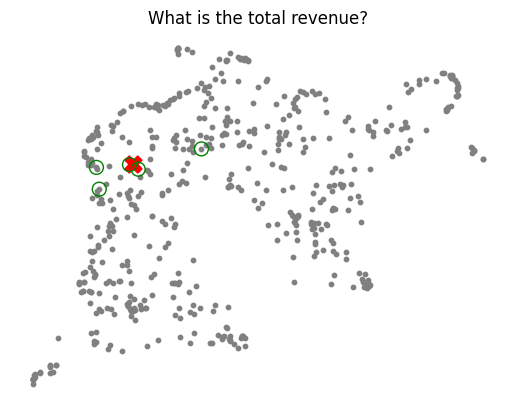

In [78]:
query = "What is the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]


query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

# prep for visualizing the embeddings and queries
projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

# print outputs
output = rag(query=query, retrieved_documents=retrieved_documents)

print(word_wrap(output))

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

### An irrelevant query and its retrieval

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


The information provided is related to Tesla automobile sales and
services in different locations around the world. Lionel Messi is not
mentioned in the information provided. Therefore, it is not possible to
determine Lionel Messi's favorite team based on this information.


(-5.642355990409851, 6.435305190086365, 3.954787564277649, 12.974955725669862)

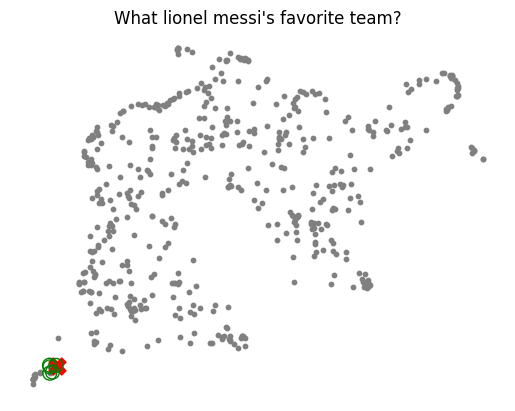

In [79]:
query = "What lionel messi's favorite team?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]


query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

# prep for visualizing the embeddings and queries
projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

# print outputs
output = rag(query=query, retrieved_documents=retrieved_documents)

print(word_wrap(output))

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')


## Query augmentation with multiple queries


In [94]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [95]:
# original_query = "What were the most important factors that contributed to increases in revenue?"
original_query = "Was there significant turnover in the executive team?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

What were the company's total revenue and net income for the fiscal year?  
Can you provide details on the company's major business segments or divisions?  
What were the key factors that influenced the company's financial performance during the year?  
Did the company make any significant investments or acquisitions during the reporting period?  
What is the outlook or guidance provided by the company for the next fiscal year?


In [96]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: Was there significant turnover in the executive team?

Results:
item 11. executive compensation 95 item 12. security ownership of
certain beneficial owners and management and related stockholder
matters 95 item 13. certain relationships and related transactions, and
director independence 95 item 14. principal accountant fees and
services 95 part iv. item 15. exhibits and financial statement
schedules 96 item 16. summary 111 signatures

table of contents we believe that sound corporate governance is
critical to helping us achieve our goals, including with respect to
esg. we continue to evolve a governance framework that exercises
appropriate oversight of responsibilities at all levels throughout the
company and manages its affairs consistent with high principles of
business ethics. our esg sustainability council is made up of leaders
from across our company, and regularly presents to our board of
directors, which oversees our esg impacts, initiatives and priorities.
human capital

In [97]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


In [98]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# after deduplication, 30 results are used

100%|██████████| 30/30 [00:10<00:00,  2.94it/s]


(-5.642355990409851, 6.435305190086365, 3.954787564277649, 12.974955725669862)

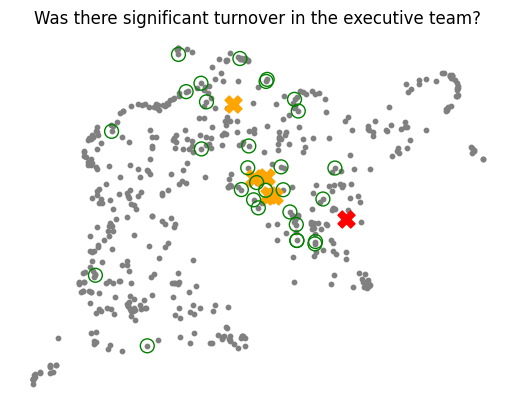

In [100]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

* we covered lot of area with the augmented questions, which help to minimize false negative 

# Re-ranking the long tail

* We need to evaluate all retrieved documents before we send to LLM for final answer 

In [131]:
queries = [original_query] + augmented_queries

results = chroma_collection.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [132]:
# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

unique_documents = list(unique_documents)

In [133]:
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

* cross encoder to classify the answer and provide the ranking scores

In [134]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
scores = cross_encoder.predict(pairs)
